# Project 1
Hexi Meng UID:406300552

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import re
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk import pos_tag
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.corpus import stopwords, wordnet
from string import punctuation

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.decomposition import TruncatedSVD,NMF
from scipy.sparse import random as sparse_random_matrix
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import (
    accuracy_score,
    auc,
    confusion_matrix,
    f1_score,
    mean_squared_error,
    precision_score,
    recall_score,
    roc_curve,
)

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB

In [25]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/furymeng/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/furymeng/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/furymeng/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/furymeng/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /Users/furymeng/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloadi

True

# Getting familiar with the dataset

In [26]:

# get row and columns of the CSV 
df = pd.read_csv('/Users/furymeng/Downloads/data.csv')
print(df.shape[0] , df.shape[1] )

3476 8


# question1
--There are 3476 rows and 8 columns in the datasheet

--Histogram: see below

--plots : see below


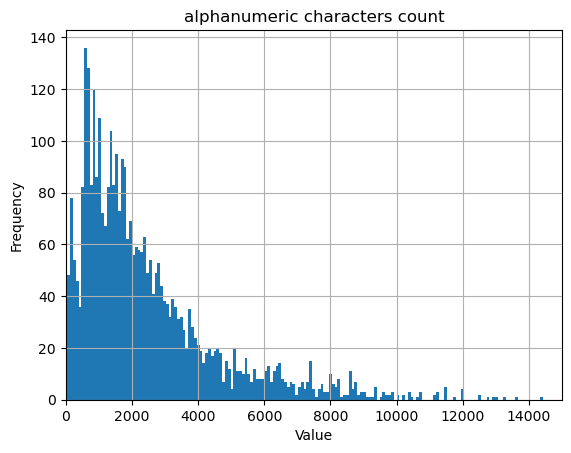

In [27]:

#define a function to count alphanumeric characters
def count_alnum(text):
    return sum(char.isalnum() for char in str(text))

#apply function to each row 
plot = df['full_text'].apply(count_alnum)
# Plot the histogram
plot.hist(bins=500)
#set the value to properly show the scale of the plot
plt.xlim([0, 15000])  

plt.title('alphanumeric characters count')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

Interpretation of the plot

1.Most articles have no more than 8000 alpha-numeric characters,only few article have more than 10000 alpha-numeric characters

2.The distribution of alphanumeric character counts is right-skewed, as most of the data points are clustered on the left side of the histogram

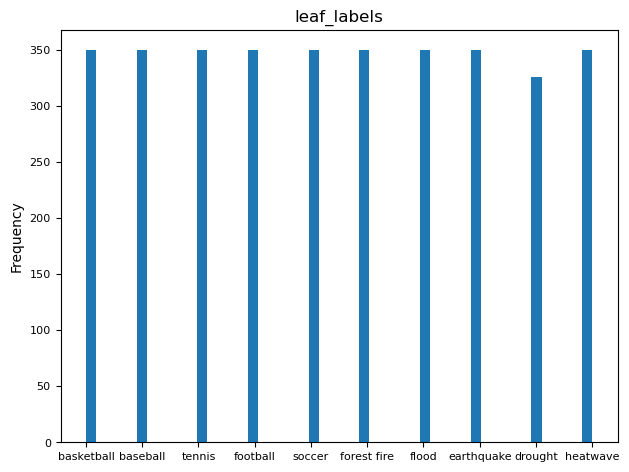

In [28]:
#read leaf_label column
leaf_label = df['leaf_label']
# Plot the histogram
plt.hist(leaf_label,bins=50)

plt.title('leaf_labels')
plt.ylabel('Frequency')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout(pad=1.0)
plt.show()

Interpretation of the plot

1.All the leaf label sports occurs about same amount time in the dataset,roughly 350 times ,except the drought


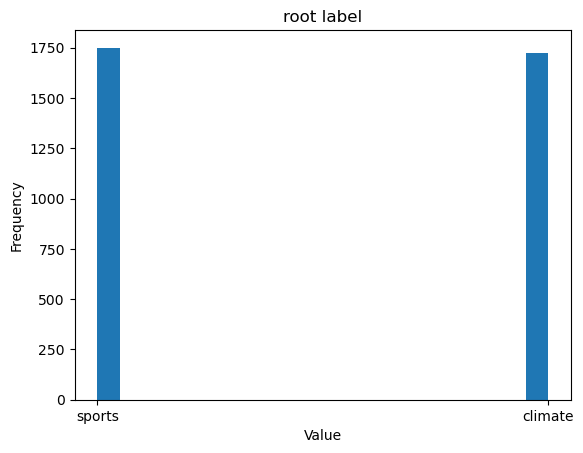

In [29]:
# read root_label column
root_label = df['root_label']
# Plot the histogram
plt.hist(root_label,bins=20)

plt.title('root label')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

Interpretation of the plot

1.There are same number of articles related to sports as related to climate,both 1750 articles related to each of the two topic

# Binary Classification

In [30]:
#split data set into train and test arrays
train, test = train_test_split(df[["full_text","root_label"]], test_size=0.2)
print('number of training samples :',train.shape[0])
print('number of test samples :',test.shape[0])

number of training samples : 2780
number of test samples : 696


# Question 2
number of training samples : 2780

number of test samples : 696

# Feature Extraction
 set up

In [31]:
wnl = nltk.wordnet.WordNetLemmatizer()

ps = nltk.stem.PorterStemmer()

stop_words_skt = text.ENGLISH_STOP_WORDS

stop_words_en = stopwords.words('english')

combined_stopwords = set.union(set(stop_words_en),set(punctuation),set(stop_words_skt))

In [32]:
# clean function
def clean(text):
 text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
 texter = re.sub(r"<br />", " ", text)
 texter = re.sub(r"&quot;", "\"",texter)
 texter = re.sub('&#39;', "\"", texter)
 texter = re.sub('\n', " ", texter)
 texter = re.sub(' u '," you ", texter)
 texter = re.sub('`',"", texter)
 texter = re.sub(' +', ' ', texter)
 texter = re.sub(r"(!)\1+", r"!", texter)
 texter = re.sub(r"(\?)\1+", r"?", texter)
 texter = re.sub('&amp;', 'and', texter)
 texter = re.sub('\r', ' ',texter)
 clean = re.compile('<.*?>')
 texter = texter.encode('ascii', 'ignore').decode('ascii')
 texter = re.sub(clean, '', texter)
 if texter == "":
   texter = ""
 return texter

def exclude_numbers(text):
    # This regular expression pattern matches integers, negative numbers, and floating-point numbers
    pattern = re.compile(r'-?\b\d+\.?\d*\b')
    
    # Replace all occurrences of the pattern with an empty string
    return pattern.sub("", text)

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

def lemmatize_sent(list_word): 
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(list_word)]



def stem_rmv_punc(doc):
    return (word for word in lemmatize_sent(analyzer(doc)) if word not in combined_stopwords and not word.isdigit())

#adpoted steaming function
def stem_text(text):
    stemmer = PorterStemmer()
    word_tokens = word_tokenize(text)
    stemmed_output = ' '.join([stemmer.stem(w) for w in word_tokens])
    return stemmed_output

#adpoted lemmatize function
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    word_tokens = word_tokenize(text)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_tokens])
    return lemmatized_output


In [33]:
train, test = train_test_split(df[['full_text', 'root_label']], test_size=0.2)
print(train.shape)
print(test.shape)

(2780, 2)
(696, 2)


In [34]:


train = train.applymap(clean)
test = test.applymap(clean)
wnl = nltk.wordnet.WordNetLemmatizer()
analyzer = CountVectorizer().build_analyzer()
count_vect = CountVectorizer(min_df=3, stop_words='english',analyzer=stem_rmv_punc)
X_train = count_vect.fit_transform(train['full_text'])
X_test = count_vect.transform(test['full_text'])
print(X_train.shape)
print(X_test.shape)

/Users/furymeng/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:547: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


(2780, 13504)
(696, 13504)


In [35]:
tfidf_transformer = TfidfTransformer()

# recall that X_train_counts = count_vect.fit_transform(twenty_train.data)
X_train_tfidf = tfidf_transformer.fit_transform(X_train)
X_test_tfidf = tfidf_transformer.fit_transform(X_test)
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(2780, 13504)
(696, 13504)


# Question 3


### 1.
**Lemmatization**

Pros:

- **Precision**:Lemmatization has higer precision that results in more precise words since it involves a deep linguistic understanding, often using vocabularies and morphological analysis

- **Accuracy** :It converts the words into same meaningful base form

Cons:
- **Computationally heavy**:It requires more computational resources because it involves understanding the context and the grammatical rules of the language.

- **Language Dependency**:Highly dependent on the language's morphology and requires extensive language-specific resources.

**Steamming**

Pros:

- **Speed**:It is way faster than lemmatization since only use heuristic logistics to cuts off the end of words

- **Simplicity**: Easier to implement ,doesn't require knowledge about the language

Cons:

- **Lack of Accuracy**:It use simple heuristics so produces non actual words

### 2.

- Increase min_df will reduce the column number of the tfidf matrix since this reduces the overall size of the vocabulary,more words willbe filtered out.

### 3.
-  One should remove punctuation first as as they might be considered part of a word, leading to incorrect lemmatization, then lemmatize the text,then remove stopwotds to avoid missing lemmatization and finally remove the number.

###
- The size of the TF-IDF-processed train matrix is **2780 x 13635**

- The size of the TF-IDF-processed test matrix is **696 x 13635**


# Dimensionality Reduction

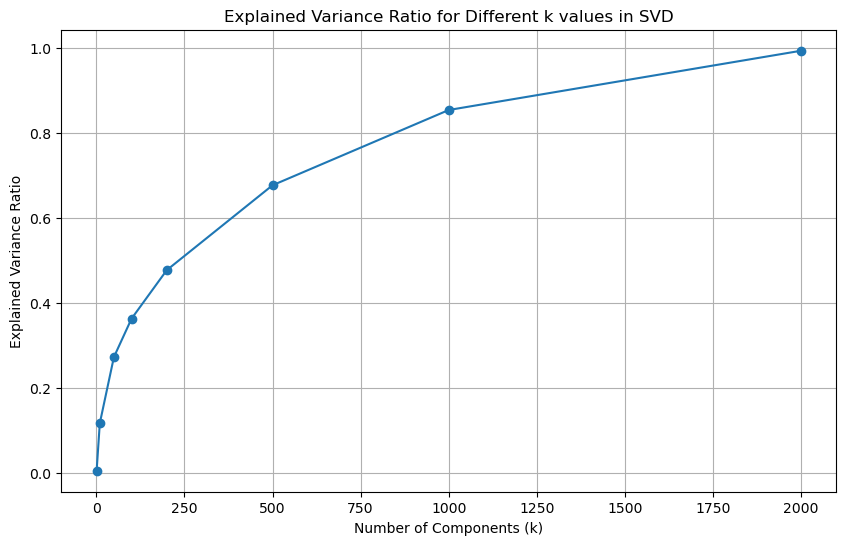

In [36]:
# k values to test
k_values = [1, 10, 50, 100, 200, 500, 1000, 2000]
explained_variance_ratios = []

for k in k_values:
    svd = TruncatedSVD(n_components=k)
    X_train_svd = svd.fit_transform(X_train_tfidf)
    X_test_svd = svd.transform(X_test_tfidf)

    explained_variance_ratios.append(svd.explained_variance_ratio_.sum())



# Plotting the explained variance ratio


plt.figure(figsize=(10, 6))
plt.plot(k_values, explained_variance_ratios, marker='o')
plt.title('Explained Variance Ratio for Different k values in SVD')
plt.xlabel('Number of Components (k)')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()



In [37]:
#LSI(SVD)
svd = TruncatedSVD(n_components=50)

X_train_svd = svd.fit_transform(X_train_tfidf)
X_test_svd = svd.transform(X_test_tfidf)
X_lsi = svd.inverse_transform(X_train_svd)
#NMF
nmf = NMF(n_components=50, init='random', random_state=2)
W = nmf.fit_transform(X_train_tfidf)
H = nmf.components_
X_nmf = np.dot(W, H)

mse_lsi = mean_squared_error(X_train_tfidf.toarray(), X_lsi)
mse_nmf = mean_squared_error(X_train_tfidf.toarray(), X_nmf)

print("MSE for LSI:", mse_lsi)
print("MSE for NMF:", mse_nmf)



/Users/furymeng/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


MSE for LSI: 5.20721509137753e-05
MSE for NMF: 5.280825171143212e-05


# Question 4

- The graph looks like a log exponential curve,increase rapidly then converging,concavity suggesting that as K increases explained variance ration saturated 

- LSI has smaller MSE than NMF , because LSI, via SVD, captures the best lower-rank approximation in the least-squares sense. NMF, on the other hand, imposes non-negativity constraints which may lead to a less optimal fit in terms of least squares.

# Classification Algorithms

In [48]:
# Assuming 'train' and 'test' are your DataFrame containing the training and testing data
X_train_label = train["root_label"].copy()
X_test_label = test["root_label"].copy()

# Convert categorical label to 0 and 1
X_train_label = X_train_label.replace({'sports': 1, 'climate': 0}).astype(int)
X_test_label = X_test_label.replace({'sports': 1, 'climate': 0}).astype(int)



svm_1000 = SVC(C=1000, kernel='linear', probability=True)
svm_00001 = SVC(C=0.0001, kernel='linear', probability=True)


pipeline_hard_margin = Pipeline([('reduce_dim', TruncatedSVD(n_components=50)),('svm', svm_1000),])
pipeline_soft_margin = Pipeline([('reduce_dim', TruncatedSVD(n_components=50)),('svm', svm_00001),])


In [49]:
#roc plot function
def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()

    roc_auc = auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)

def fit_predict_and_plot_roc(pipe, train_data, train_label, test_data, test_label):
    pipe.fit(train_data, train_label)
    # pipeline1.predict(twenty_test.data)

    if hasattr(pipe, 'decision_function'):
        prob_score = pipe.decision_function(test_data)
        fpr, tpr, _ = roc_curve(test_label, prob_score)
    else:
        prob_score = pipe.predict_proba(test_data)
        fpr, tpr, _ = roc_curve(test_label, prob_score[:,1])

    plot_roc(fpr, tpr)
    return pipe

Confusion matrix is:
 [[335  22]
 [ 21 318]]
Accuracy:  0.9382183908045977
Recall:  0.9380530973451328
Precision:  0.9352941176470588
F-1 score:  0.9366715758468336


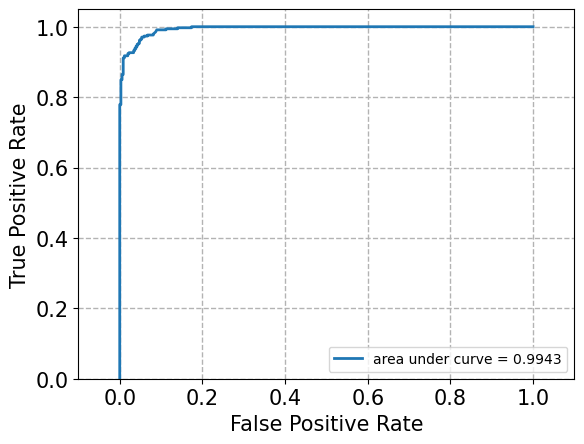

In [67]:


# gamma = 1000
fit_predict_and_plot_roc(pipeline_hard_margin, X_train_tfidf, X_train_label, X_test_tfidf, X_test_label)


predictions = svm_1000.predict(X_test_svd)

# output
confusion_matrix = metrics.confusion_matrix(X_test_label, predictions)
accuracy = metrics.accuracy_score(X_test_label, predictions)
recall = metrics.recall_score(X_test_label, predictions)
precision = metrics.precision_score(X_test_label, predictions)
f1 = metrics.f1_score(X_test_label, predictions)

# Output results
print("Confusion matrix is:\n", confusion_matrix)
print("Accuracy: ", accuracy)
print("Recall: ", recall)
print("Precision: ", precision)
print("F-1 score: ", f1)


Confusion matrix is:
 [[  0 357]
 [  0 339]]
Accuracy:  0.4870689655172414
Recall:  1.0
Precision:  0.4870689655172414
F-1 score:  0.655072463768116


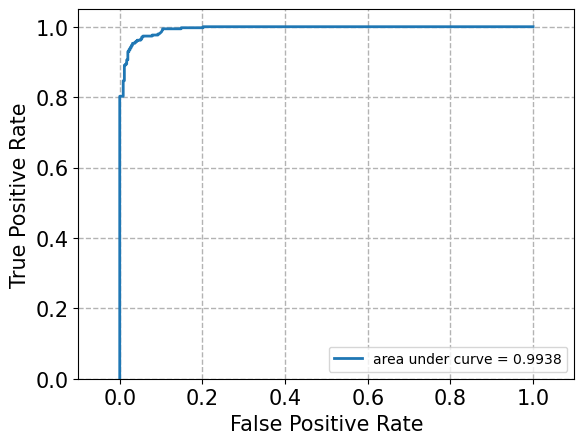

In [68]:
# gamma = 0.0001
fit_predict_and_plot_roc(pipeline_hard_margin, X_train_tfidf, X_train_label, X_test_tfidf, X_test_label)


predictions = svm_00001.predict(X_test_svd)

# output
confusion_matrix = metrics.confusion_matrix(X_test_label, predictions)
accuracy = metrics.accuracy_score(X_test_label, predictions)
recall = metrics.recall_score(X_test_label, predictions)
precision = metrics.precision_score(X_test_label, predictions)
f1 = metrics.f1_score(X_test_label, predictions)

# Output results
print("Confusion matrix is:\n", confusion_matrix)
print("Accuracy: ", accuracy)
print("Recall: ", recall)
print("Precision: ", precision)
print("F-1 score: ", f1)

Confusion matrix is:
 [[340  17]
 [ 14 325]]
Accuracy:  0.9554597701149425
Recall:  0.9587020648967551
Precision:  0.9502923976608187
F-1 score:  0.9544787077826725


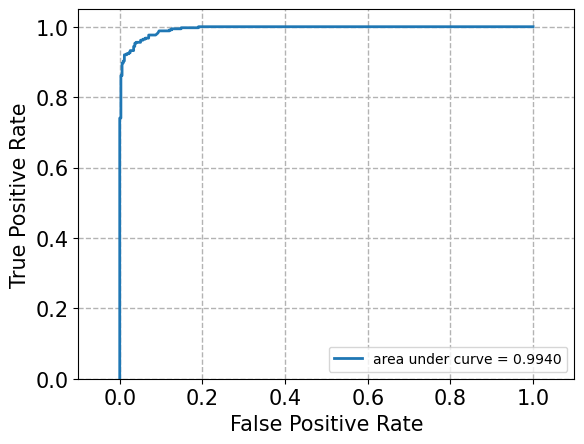

In [69]:

# gamma = 100000
svm_100000 = SVC(C=100000, kernel='linear', probability=True)
pipeline_gamma_100000 = Pipeline([('reduce_dim', TruncatedSVD(n_components=50)),('svm', svm_100000),])

# Use the correct pipeline for gamma=100000
fit_predict_and_plot_roc(pipeline_gamma_100000, X_train_tfidf, X_train_label, X_test_tfidf, X_test_label)

svm_100000.fit(X_train_svd, X_train_label)

# Predict using svm_100000
predictions = svm_100000.predict(X_test_svd)

# output
confusion_matrix = metrics.confusion_matrix(X_test_label, predictions)
accuracy = metrics.accuracy_score(X_test_label, predictions)
recall = metrics.recall_score(X_test_label, predictions)
precision = metrics.precision_score(X_test_label, predictions)
f1 = metrics.f1_score(X_test_label, predictions)

# Output results
print("Confusion matrix is:\n", confusion_matrix)
print("Accuracy: ", accuracy)
print("Recall: ", recall)
print("Precision: ", precision)
print("F-1 score: ", f1)




In [70]:
c=[10**-3, 10**-2, 10**-1, 10, 100, 1000, 10000, 100000, 100000]


validation_accuracy=[]

for i in c:
  svm_opt = SVC(C=i)
  scores = cross_val_score(svm_opt, X_train_svd, X_train_label, cv=5)
  scores = scores.mean()
  validation_accuracy.append(scores)

print(validation_accuracy)
max_accuracy = max(validation_accuracy)
max_index = validation_accuracy.index(max_accuracy)
optimal_c = c[max_index]

print("Optimal C value:", optimal_c)
print("Maximum accuracy:", max_accuracy)


[0.5075539568345324, 0.8971223021582734, 0.9478417266187049, 0.9607913669064747, 0.9622302158273381, 0.9568345323741008, 0.9557553956834532, 0.9557553956834532, 0.9557553956834532]
Optimal C value: 100
Maximum accuracy: 0.9622302158273381


Confusion matrix is:
 [[340  17]
 [ 12 327]]
Accuracy:  0.9583333333333334
Recall:  0.9646017699115044
Precision:  0.9505813953488372
F-1 score:  0.9575402635431918


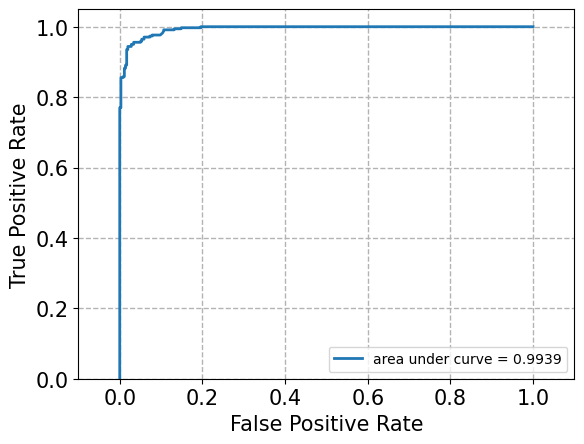

In [71]:
# optimal gamma = 100

svm_100 = SVC(C=100, kernel='linear', probability=True)
pipeline_gamma_100 = Pipeline([('reduce_dim', TruncatedSVD(n_components=50)),('svm', svm_100),])

fit_predict_and_plot_roc(pipeline_hard_margin, X_train_tfidf, X_train_label, X_test_tfidf, X_test_label)

svm_100.fit(X_train_svd, X_train_label)

predictions = svm_100.predict(X_test_svd)

# output
confusion_matrix = metrics.confusion_matrix(X_test_label, predictions)
accuracy = metrics.accuracy_score(X_test_label, predictions)
recall = metrics.recall_score(X_test_label, predictions)
precision = metrics.precision_score(X_test_label, predictions)
f_1 = metrics.f1_score(X_test_label, predictions)

# Output results
print("Confusion matrix is:\n", confusion_matrix)
print("Accuracy: ", accuracy)
print("Recall: ", recall)
print("Precision: ", precision)
print("F-1 score: ", f_1)


# Question 5

####
- See results above

- See output graph above

- hard margin performs better, for γ = 100000 , the accuracy decreases possibily due to training data overfitting

- 

- best value of γ = 100

  Confusion matrix is:
   
       [[340  17]
  
        [12 327]]

   Accuracy:  0.9583333333333334

   Recall:  0.9646017699115044

   Precision:  0.9505813953488372

   F-1 score:  0.9575402635431918


# Logistic regression



/Users/furymeng/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Confusion matrix is:
 [[349   8]
 [ 12 327]]
Accuracy is: 0.9712643678160919
Recall is: 0.9646017699115044
Precision is: 0.9761194029850746
F-1 score is: 0.9703264094955489


/Users/furymeng/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


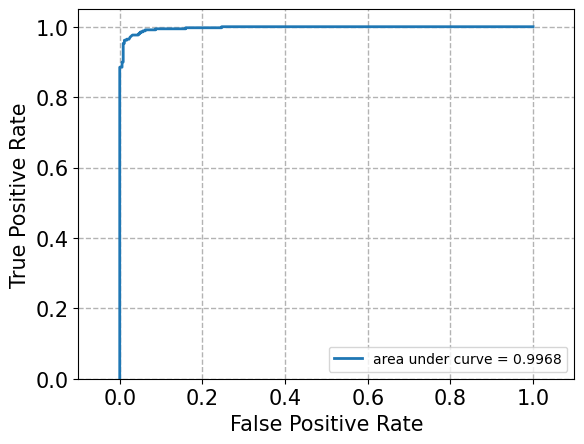

In [73]:
pipeline_log = LogisticRegression(penalty="none", max_iter=1000000)

# Fit and plot ROC curve using the pipeline
fit_predict_and_plot_roc(pipeline_log, X_train_tfidf, X_train_label, X_test_tfidf, X_test_label)

# Make predictions using the pipeline
pipeline_log.fit(X_train_tfidf, X_train_label)
predictions = pipeline_log.predict(X_test_tfidf)

#output
confusion_matrix = metrics.confusion_matrix(X_test_label, predictions)
accuracy = metrics.accuracy_score(X_test_label, predictions)
recall = metrics.recall_score(X_test_label, predictions)
precision = metrics.precision_score(X_test_label, predictions)
f1 = metrics.f1_score(X_test_label, predictions)

# Output results
print("Confusion matrix is:\n", confusion_matrix)
print("Accuracy is:", accuracy)
print("Recall is:", recall)
print("Precision is:", precision)
print("F1 score is:", f1)


In [78]:
pipe_l1 = Pipeline([
    ('reduce_dim', TruncatedSVD(n_components=50)),
    ('log_reg', LogisticRegression(penalty='l1', solver='liblinear'))
])

pipe_l2 = Pipeline([
    ('reduce_dim', TruncatedSVD(n_components=50)),
    ('log_reg', LogisticRegression(penalty='l2'))
])

# Define the parameter grid
param_grid = {'log_reg__C': np.logspace(-5, 5, 11)}

# Grid search with 5-fold cross-validation
grid_search_l1 = GridSearchCV(pipe_l1, param_grid, cv=5, scoring='accuracy')
grid_search_l2 = GridSearchCV(pipe_l2, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search_l1.fit(X_train_svd, X_train_label)
grid_search_l2.fit(X_train_svd, X_train_label)

# Best parameters 
print("Best parameters (L1):", grid_search_l1.best_params_)
print("Best parameters (L2):", grid_search_l2.best_params_)

/Users/furymeng/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/furymeng/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

Best parameters (L1): {'log_reg__C': 10.0}
Best parameters (L2): {'log_reg__C': 100.0}


/Users/furymeng/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/furymeng/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

In [80]:

# Create logistic regression models
log_reg_0 = LogisticRegression(penalty="none", max_iter=100000)
log_reg_l1 = LogisticRegression(penalty="l1", C=10, solver='liblinear', max_iter=100000)
log_reg_l2 = LogisticRegression(penalty="l2", C=100, max_iter=100000)

# Fit the models
log_reg_0.fit(X_train_svd, X_train_label)
log_reg_l1.fit(X_train_svd, X_train_label)
log_reg_l2.fit(X_train_svd, X_train_label)

# Evaluate each model
models = {
    "No Regularization": log_reg_0,
    "L1 Regularization": log_reg_l1,
    "L2 Regularization": log_reg_l2
}

for name, model in models.items():
    predictions = model.predict(X_test_svd)
    accuracy = accuracy_score(X_test_label, predictions)
    precision = precision_score(X_test_label, predictions)
    recall = recall_score(X_test_label, predictions)
    f1 = f1_score(X_test_label, predictions)

    print(f"Results for {name}:")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("\n")

Results for No Regularization:
Accuracy: 0.9568965517241379
Precision: 0.9504373177842566
Recall: 0.9616519174041298
F1 Score: 0.9560117302052786


Results for L1 Regularization:
Accuracy: 0.9540229885057471
Precision: 0.9475218658892128
Recall: 0.9587020648967551
F1 Score: 0.9530791788856304


Results for L2 Regularization:
Accuracy: 0.9525862068965517
Precision: 0.9447674418604651
Recall: 0.9587020648967551
F1 Score: 0.9516837481698389




/Users/furymeng/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


# Quesion6
- Best parameters (L1): 10.0
  
  Best parameters (L2): 100.0

- See output above for performance regarding w/o regularization, w/ L1 regularization and w/ L2 regularization 

- Higher regulating parameters reduces testing error, however, if 'C' is too high, the model may start overfitting, and the test error could increase.**L1** can shrink some coefficients to zero, effectively removing those features from the model and make the model simpler therefore it is preferred when we need a sparse model with fewer features whereas **L2** does not result in feature elimination. It can be preferred when all features are expected to contribute,also decreasing the model complexity and  increase the stability of the model

- Logistic Regression vs SVM:
Logistic regression derive the decision boundary based on the probability estimates(minimum loglikelyhood), linear SVM's decision boundary is determined by the support vectors and the margin,
As a result SVMs can perform better when there's a clear margin of separation in the data, whereas logistic regression can be more robust to overlapping class distributions.Therefore their performance really depend on the types of dataset,if the dataset is large, logistic regression might be more suitable, whereas if the set is high-dimensional data where a clear margin is present, an SVM might offer better performance.




# Naive Bayes Model

In [ ]:
# Create and train Gaussian Naive Bayes classifier
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Predictions and Evaluation
predictions = gnb.predict(X_test)